# Домашнее задание по теме  
## «Снижение размерности. Алгоритм PCA»

Импорт библиотек

In [ ]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

import umap.umap_ as umap

### Загрузка данных

In [2]:
# Загрузка данных
archive_path = 'input_data/penguins.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('penguins.csv') as file:
        df = pd.read_csv(file)

### Подготовка исходных данных, EDA

In [3]:
df.info(memory_usage=True) # Вывод столбцов и их типов
df.head() # Вывод "шапки"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
# Проверка на дубликаты записей
df_duplicated = df[df.duplicated(keep=False)]
# Количество дублированных строк
duplicated_rows = len(df_duplicated)
df_rows = len(df)
print(f'Всего строк: {df_rows}')
print(f'Дублированных строк: {duplicated_rows}  {duplicated_rows/df_rows:.2%}')

Всего строк: 344
Дублированных строк: 2  0.58%


In [6]:
# Удление дубликатов
df = df.drop_duplicates()  

In [7]:
# Анализ пропущенных значений
print(df.isnull().sum())

culmen_length_mm     1
culmen_depth_mm      1
flipper_length_mm    1
body_mass_g          1
sex                  8
dtype: int64


In [ ]:
# Пропусков не много, удаляю
df = df.dropna()

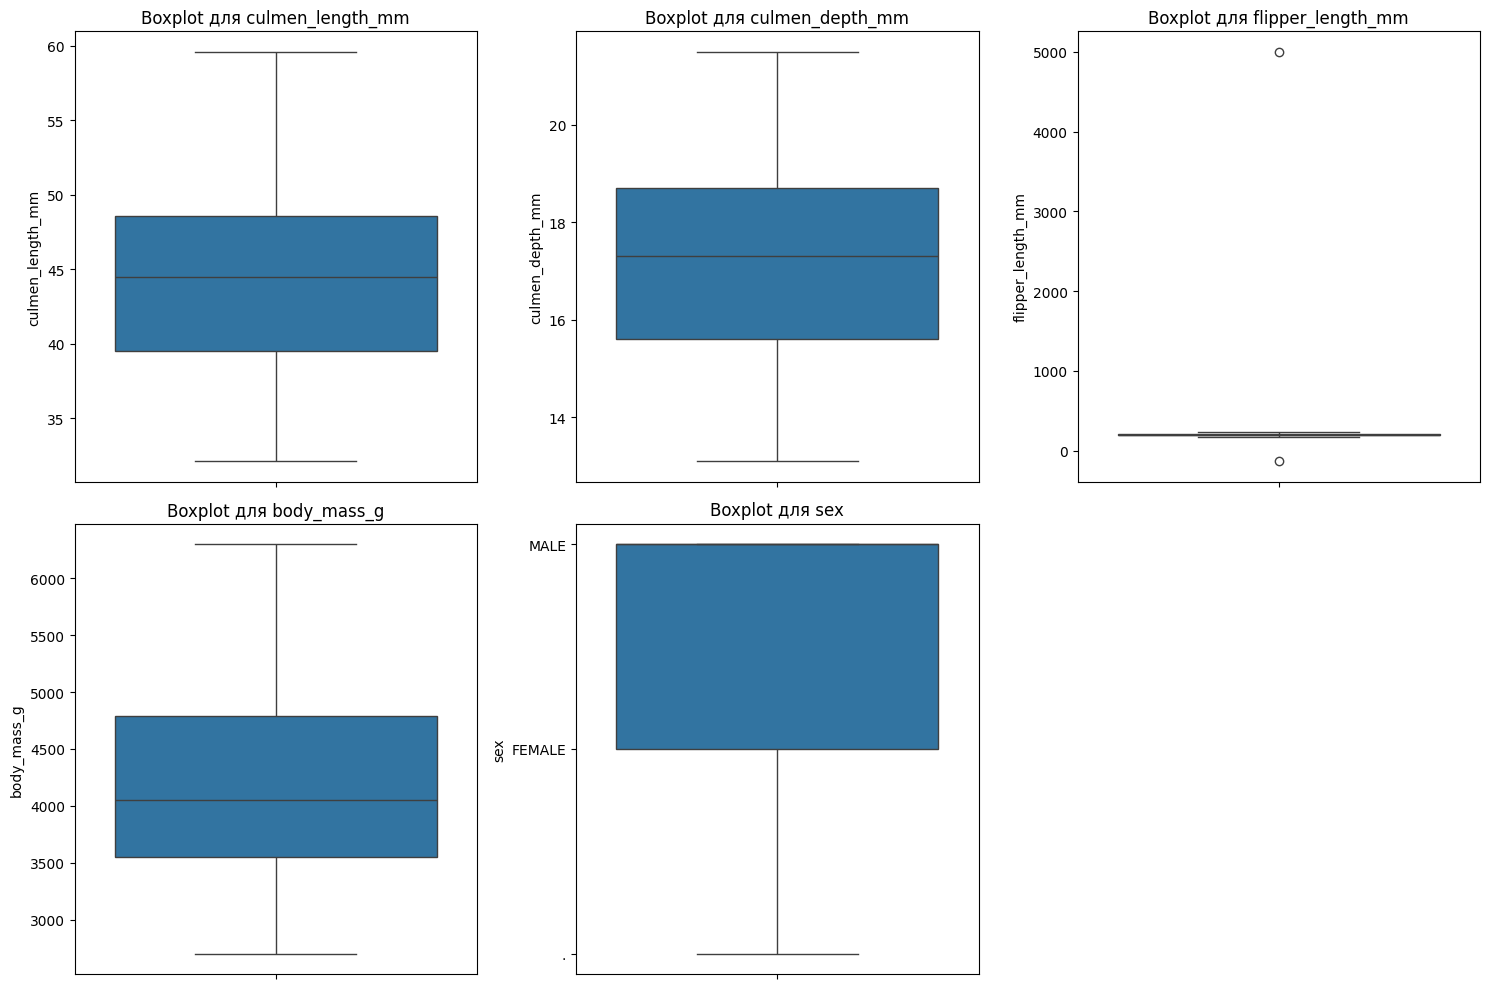

In [9]:
# Box-plot для столбцов
n_cols = 3  # Количество столбцов
n_rows = (len(df.columns) + n_cols - 1) // n_cols  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

if len(df.columns) % n_cols != 0:
    for i in range(len(df.columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

for i, column in enumerate(df.columns):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(y=df[column], ax=axes[row, col])  
    axes[row, col].set_title(f'Boxplot для {column}')

plt.tight_layout()
plt.show()

In [10]:
max_value = df['flipper_length_mm'].max()
min_value = df['flipper_length_mm'].min()

print(f'max: {max_value}')
print(f'min: {min_value}')

max: 5000.0
min: -132.0


В flipper_length_mm имеются значительные выбросы по верху и низу
- длинна плавника 5000мм - это не кит - удаляю
- длинна плавника отрицательная - удаляю

In [11]:
# Удаление выбросов
df = df[df['flipper_length_mm'] != max_value]
df = df[df['flipper_length_mm'] != min_value]

In [12]:
#  Признак 'sex' удаляю что бы не влиял на результат
df = df.drop(columns=['sex'])

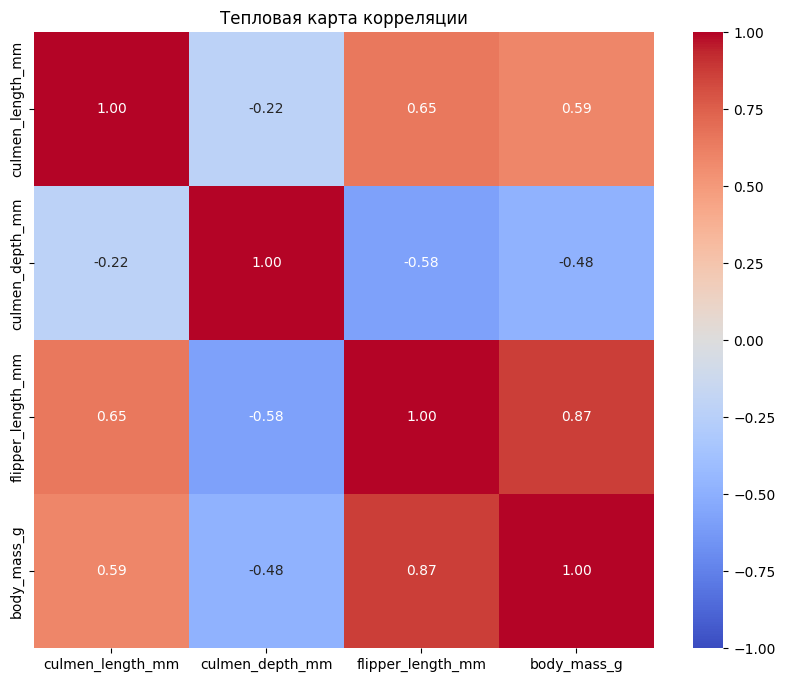

In [13]:
# Тепловая карта корреляций
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Тепловая карта корреляции')
plt.show()

В наборе данных значительная корреляция между категориями

In [14]:
# Стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(data_scaled)

### Применение метода снижения размерности Kernel PCA

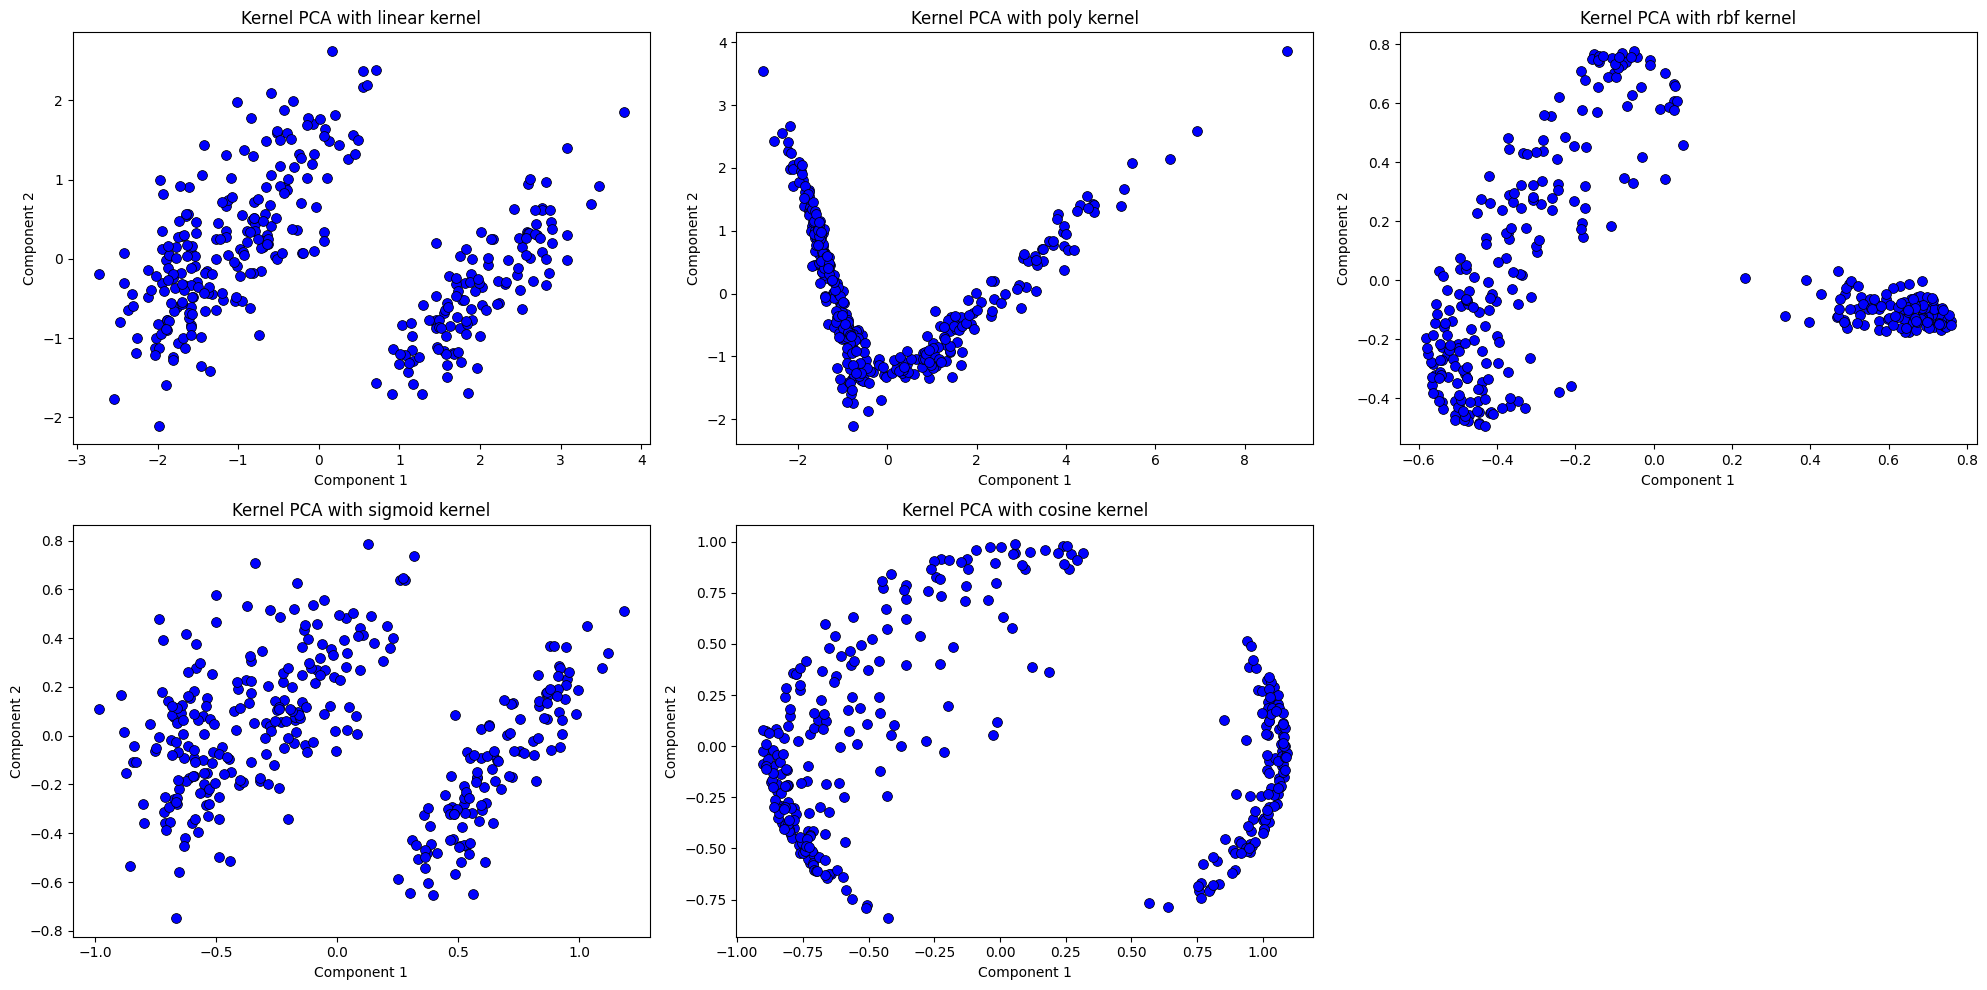

In [15]:
# Список ядерных функций
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

# Применение Kernel PCA для каждого ядра для 2-х компонент
plt.figure(figsize=(20, 10))
for i, kernel in enumerate(kernels):
    # Экземпляр KernelPCA
    kpca = KernelPCA(n_components=2, kernel=kernel, fit_inverse_transform=True)
    
    # Применение Kernel PCA
    df_kpca = kpca.fit_transform(df_scaled)
    
    # Вывод графиков
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=df_kpca[:, 0], y=df_kpca[:, 1], c='blue', edgecolor='k', s=50)
    plt.title(f'Kernel PCA with {kernel} kernel')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
plt.tight_layout()
plt.show()

Вывод: Для всех ядер кроме poly присутсвует четкое разделение на кластеры

### Расчет дисперсии и lost_variance для линейного ядра

In [16]:
kpca_linear = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
df_kpca_linear = kpca_linear.fit_transform(df_scaled)

# Дисперсия
explained_variance = np.var(df_kpca_linear, axis=0)
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_variance

# lost_variance
lost_variance = 1 - np.sum(explained_variance_ratio)

print(f"Explained variance ratio: {explained_variance_ratio}")
print(f"Lost variance: {lost_variance}")

Explained variance ratio: [0.77775098 0.22224902]
Lost variance: 1.1102230246251565e-16


Вывод: 
- первая компонента объясняет 77,78% дисперсии данных. Являеттся наиболее важной.
- вторая компонента объясняет 22,22% дисперсии данных. Добавляет доп.информацию но ее вклад ниже.
- при использовании 2-х компонент данные не теряют своей информативности

### Примение для сравнения алгоритма t-SNE и UMAP

t-SNE

In [17]:
# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

UMAP

In [ ]:
# Применение UMAP
umap_reducer = umap.UMAP(random_state=42)
df_umap = umap_reducer.fit_transform(df_scaled)

Графики

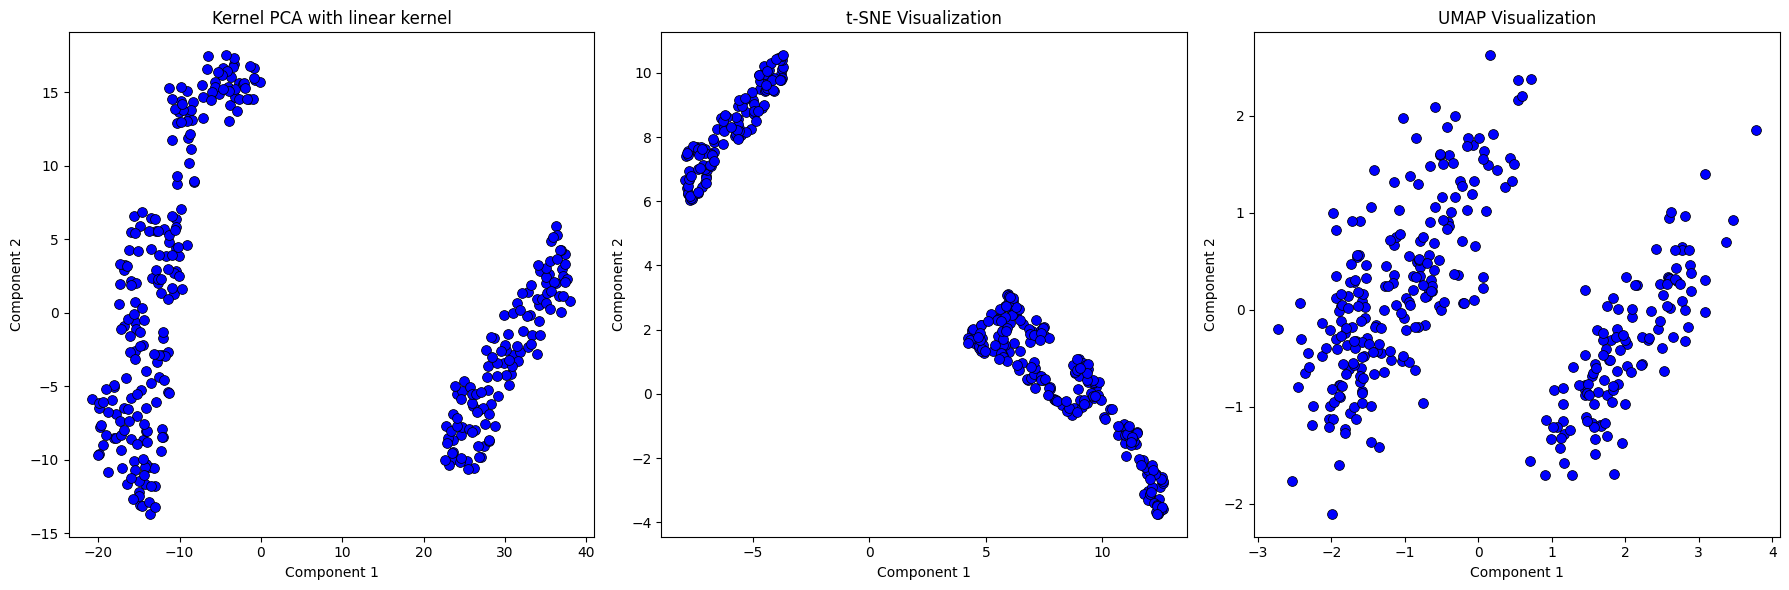

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Kernel PCA
sns.scatterplot(x=df_kpca_linear[:, 0], y=df_kpca_linear[:, 1], ax=axes[2], c='blue', edgecolor='k', s=50)
axes[0].set_title(f'Kernel PCA with linear kernel')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')

# t-SNE
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], ax=axes[0], c='blue', edgecolor='k', s=50)
axes[1].set_title('t-SNE Visualization')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')

# UMAP
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], ax=axes[1], c='blue', edgecolor='k', s=50)
axes[2].set_title('UMAP Visualization')
axes[2].set_xlabel('Component 1')
axes[2].set_ylabel('Component 2')

plt.tight_layout()
plt.show()

Вывод:
- расположение кластеров на графиках не одинаковое
- все три алгоритма замечательно справились с кластеризацией текущего набора данных